In [82]:
## Importing required libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import itertools

import matplotlib.pyplot as plt
#import tensorflow

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, make_scorer, f1_score, recall_score, log_loss, precision_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

from time import time
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score


from tensorflow import keras
from keras.utils.np_utils import to_categorical
from keras import backend as K
from tensorflow.keras.optimizers import RMSprop

from time import time
import warnings
import os

warnings.simplefilter("ignore")

### Read processed data from file

<p>Reading the labels and the features</p>

In [33]:
# Upload data

labels = pd.read_csv("labels.csv")
labels = labels.replace({'Defeat': 0}, regex=True)
labels = labels.replace({'Draw': 1}, regex=True)
labels = labels.replace({'Win': 2}, regex=True)
labels = labels.drop('Unnamed: 0', axis=1)


features = pd.read_csv("features.csv")
features.rename( columns={'Unnamed: 0':'match'}, inplace=True )
features = features.drop('match', axis=1)

features_min = pd.read_csv("features_min.csv")
features_min.rename( columns={'Unnamed: 0':'match'}, inplace=True )
features_min = features_min.drop('match', axis=1)


## "one-hot" encoding

In [34]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [35]:
labels

array([2, 0, 2, ..., 0, 2, 2], dtype=int64)

### Classification

Use of DecisionTreeClassifier with and without k-fold cross-validation,  GridSearchCV for parameter tunning 
and use of Random Forest Classifiers


In [80]:
# Metrics
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'neg_log_loss']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

#all_inputs[:5]

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(features, labels, test_size=0.25, random_state=1)



### Decision Tree

In [6]:
# decion tree classifier (not very good classifier)
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
decision_tree_classifier.score(testing_inputs, testing_classes)

0.406062874251497

(array([2., 1., 0., 2., 0., 2., 1., 0., 1., 1.]),
 array([0.40381737, 0.40581961, 0.40782186, 0.4098241 , 0.41182635,
        0.41382859, 0.41583084, 0.41783308, 0.41983533, 0.42183757,
        0.42383982]),
 <a list of 10 Patch objects>)

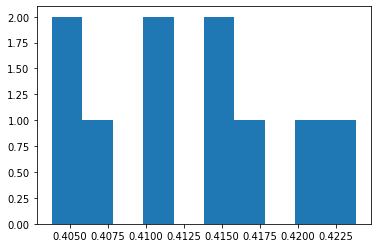

In [7]:
## from this we can see that the problem is dependent on the subset we are
# using => overfitting
model_accuracies = []

for repetition in range(10):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(features, labels, test_size=0.25)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
plt.hist(model_accuracies)


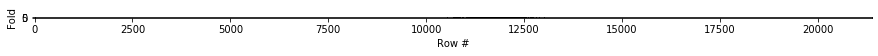

In [26]:
## cross validation
def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(masks, interpolation='none', cmap='gray_r')
    plt.ylabel('Fold')
    plt.xlabel('Row #')

plot_cv(StratifiedKFold(n_splits=10), features, labels)

''

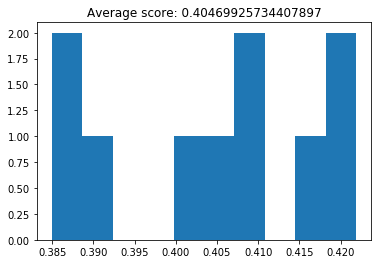

In [25]:
# Now we have a more consistent rating: however it is not that good
decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, features, labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

Text(0.5, 1.0, 'Average score: 0.5254052501846175')

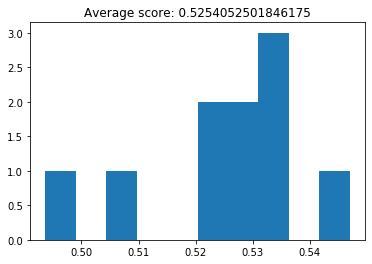

In [9]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=1)

cv_scores = cross_val_score(decision_tree_classifier, features, labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

Text(0.5, 1.0, 'Average score: 0.5254052501846175')

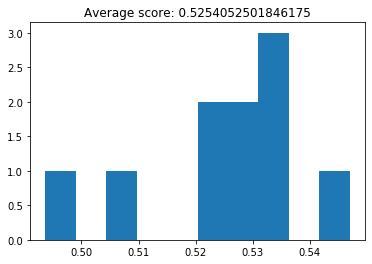

In [10]:
## MINIFIED


StratifiedKFold(n_splits=10)

decision_tree_classifier = DecisionTreeClassifier(max_depth=2)

cv_scores = cross_val_score(decision_tree_classifier, features_min, labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [83]:
from sklearn.model_selection import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation, scoring=scoring, refit='accuracy', return_train_score=True)

start = time()     
grid_search.fit(features_min, labels)
end = time()    
bestIndex = grid_search.best_params_['max_depth'] - 1 + (( grid_search.best_params_['max_features']  - 1) * 5)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Precision: {}'.format(grid_search.cv_results_['mean_test_precision_macro'][bestIndex]))
print('Recall: {}'.format(grid_search.cv_results_['mean_test_recall_macro'][bestIndex]))
print('F1_score: {}'.format(grid_search.cv_results_['mean_test_f1_macro'][bestIndex]))
print('Loss: {}'.format(grid_search.cv_results_['mean_test_neg_log_loss'][bestIndex]))
print("Time {:.1f} (seconds)".format((end - start)))

Best score: 0.5254052501846175
Best parameters: {'max_depth': 1, 'max_features': 10}
Precision: 0.3648305381415381
Recall: 0.4353839074990512
F1_score: 0.37805233542016764
Loss: -1.0333080781922828
Time 31.0 (seconds)


''

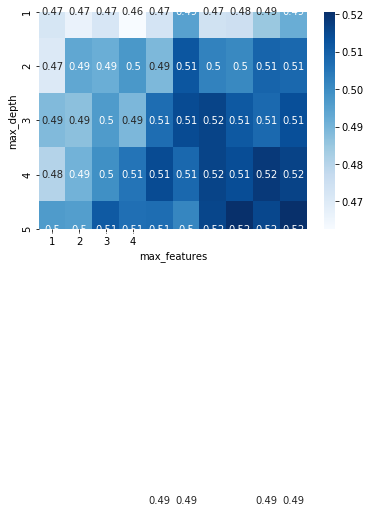

In [41]:
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (10, 10)
sns.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')
;

In [34]:

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(features, labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.5121643117806681
Best parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 4, 'splitter': 'best'}


Text(0.5, 1.0, 'Average score: 0.5247973147182279')

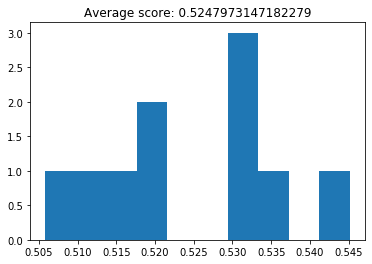

In [84]:
from sklearn.ensemble import RandomForestClassifier

StratifiedKFold(n_splits=10)

random_forest_classifier = RandomForestClassifier(max_depth=4)

cv_scores = cross_val_score(random_forest_classifier, features, labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [86]:

random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [10, 25, 50, 100],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4],
                 'max_depth': [1, 2, 3, 4, 5]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation, scoring=scoring, refit='accuracy', return_train_score=True)

start = time()     
grid_search.fit(features_min, labels)
end = time()    

KeyError: 'max_depth'

In [108]:
# best params: {'criterion': 'entropy', 'max_features': 1, 'n_estimators': 100}
bestIndex = (16 - 1) + (1 - 1) + (4 - 1) + 1
print('Best score: {}'.format(grid_search.cv_results_['mean_test_accuracy'][bestIndex]))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Precision: {}'.format(grid_search.cv_results_['mean_test_precision_macro'][bestIndex]))
print('Recall: {}'.format(grid_search.cv_results_['mean_test_recall_macro'][bestIndex]))
print('F1_score: {}'.format(grid_search.cv_results_['mean_test_f1_macro'][bestIndex]))
print('Loss: {}'.format(grid_search.cv_results_['mean_test_neg_log_loss'][bestIndex]))
print("Time {:.1f} (seconds)".format((end - start)))

Best score: 0.50210571195818
Best parameters: {'criterion': 'entropy', 'max_features': 1, 'n_estimators': 100}
Precision: 0.4254811751533952
Recall: 0.4325453770350333
F1_score: 0.40788069772888225
Loss: -1.0218908124520516
Time 876.8 (seconds)


''

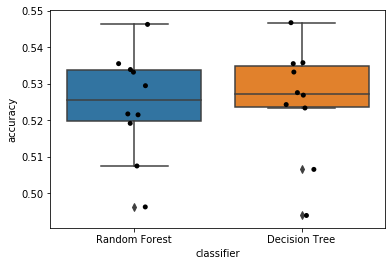

In [21]:
rf_df = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, features, labels, cv=10),
                       'classifier': ['Random Forest'] * 10})
dt_df = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, features, labels, cv=10),
                      'classifier': ['Decision Tree'] * 10})
both_df = rf_df.append(dt_df)

sns.boxplot(x='classifier', y='accuracy', data=both_df)
sns.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='black')
;

<h3>KNN Algorithm</h3>
<p> K-nearest neighbors with an Euclidean distance measure is sensitive to magnitudes and hence should be scaled for all features to weigh in equally.</p>
<p>The following one is with using 20% of the entries for test and the rest to train</p>

In [4]:
from sklearn.preprocessing import StandardScaler

X1_train, X1_test, Y1_train, Y1_test = train_test_split(features, labels, test_size=0.20)

scaler = StandardScaler()
scaler.fit(X1_train)

X1_train = scaler.transform(X1_train)
X1_test = scaler.transform(X1_test)

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X1_train, Y1_train)
y1_pred = classifier.predict(X1_test)

y1_pred = classifier.predict(X1_test)

print(confusion_matrix(Y1_test, y1_pred))
print(classification_report(Y1_test, y1_pred))

[[ 580  252  370]
 [ 390  308  422]
 [ 499  403 1051]]
              precision    recall  f1-score   support

           0       0.39      0.48      0.43      1202
           1       0.32      0.28      0.30      1120
           2       0.57      0.54      0.55      1953

    accuracy                           0.45      4275
   macro avg       0.43      0.43      0.43      4275
weighted avg       0.46      0.45      0.45      4275



<h5>Using k-fold cross validation:</h5>

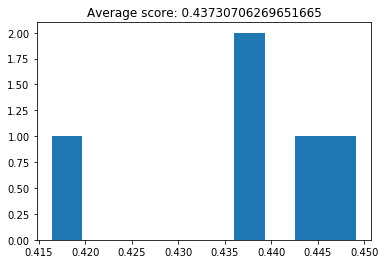

0.48755724017959656

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

knn_cv = KNeighborsClassifier(n_neighbors=5)
cv_scores = cross_val_score(knn_cv, features, labels, cv=5)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()
knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = GridSearchCV(knn2, param_grid, cv=10)
knn_gscv.fit(features, labels)
#knn_gscv.best_params_
knn_gscv.best_score_


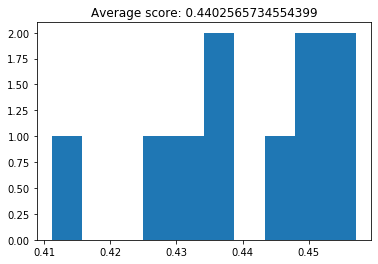

In [14]:
knn_cv = KNeighborsClassifier(n_neighbors=5)
cv_scores = cross_val_score(knn_cv, features_min, labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()

<p>Now we should try to find the best parameters</p>

In [93]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=10, 
                                    n_repeats=3, 
                                    random_state=999)


params_KNN = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7], 
              'weights': ['uniform', 'distance'],
              'p': [1, 2, 5, 8 , 16]}

grid = GridSearchCV(estimator=KNeighborsClassifier(), 
                      param_grid=params_KNN, 
                      cv=cross_validation, scoring=scoring, refit='accuracy', return_train_score=True)

start = time()     
grid_search.fit(features_min, labels)
end = time()  


In [95]:
# best params: {'criterion': 'entropy', 'max_features': 1, 'n_estimators': 100}
bestIndex = (16 - 1) + (1 - 1) + (4 - 1)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Precision: {}'.format(grid_search.cv_results_['mean_test_precision_macro'][bestIndex]))
print('Recall: {}'.format(grid_search.cv_results_['mean_test_recall_macro'][bestIndex]))
print('F1_score: {}'.format(grid_search.cv_results_['mean_test_f1_macro'][bestIndex]))
print('Loss: {}'.format(grid_search.cv_results_['mean_test_neg_log_loss'][bestIndex]))
print("Time {:.1f} (seconds)".format((end - start)))

Best score: 0.50210571195818
Best parameters: {'criterion': 'entropy', 'max_features': 1, 'n_estimators': 100}
Precision: 0.4181055568067357
Recall: 0.42821393245226347
F1_score: 0.407961002348953
Loss: -1.0568578106905948
Time 876.8 (seconds)


0.50210571195818

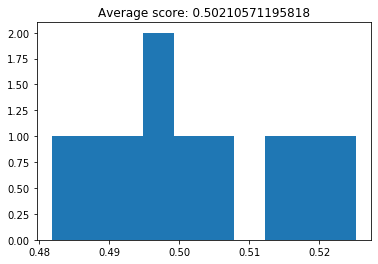

In [109]:
bestIndex = (16 - 1) + (1 - 1) + (4 - 1) + 1
cv_scores = np.array([
    grid_search.cv_results_['split0_test_accuracy'][bestIndex],
    grid_search.cv_results_['split1_test_accuracy'][bestIndex],
    grid_search.cv_results_['split2_test_accuracy'][bestIndex],
    grid_search.cv_results_['split3_test_accuracy'][bestIndex],
    grid_search.cv_results_['split4_test_accuracy'][bestIndex],
    grid_search.cv_results_['split5_test_accuracy'][bestIndex],
    grid_search.cv_results_['split6_test_accuracy'][bestIndex],
    grid_search.cv_results_['split7_test_accuracy'][bestIndex],
    grid_search.cv_results_['split8_test_accuracy'][bestIndex],
    grid_search.cv_results_['split9_test_accuracy'][bestIndex],
])
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
grid_search.cv_results_['mean_test_accuracy'][bestIndex]

In [51]:
results_KNN = pd.DataFrame(grid.cv_results_['params'])
results_KNN['test_score'] = grid.cv_results_['mean_test_score']
results_KNN['metric'] = results_KNN['p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])
results_KNN

,n_neighbors,p,test_score,metric
0,1,1,0.410989,Manhattan
1,1,2,0.412002,Euclidean
2,1,5,0.398297,Minkowski
3,2,1,0.389807,Manhattan
4,2,2,0.390178,Euclidean
5,2,5,0.369878,Minkowski
6,3,1,0.433062,Manhattan
7,3,2,0.435221,Euclidean
8,3,5,0.423803,Minkowski
9,4,1,0.430396,Manhattan


<h3>We should test different K values</h3>

In [24]:
'''
error_rate = []
for i in range(1,40):

    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,Y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != Y_test))
    
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error_rate, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')'''


"\nerror_rate = []\nfor i in range(1,40):\n\n    knn = KNeighborsClassifier(n_neighbors=i)\n    knn.fit(X_train,Y_train)\n    pred_i = knn.predict(X_test)\n    error_rate.append(np.mean(pred_i != Y_test))\n    \nplt.figure(figsize=(12, 6))\nplt.plot(range(1, 40), error_rate, color='red', linestyle='dashed', marker='o',\n         markerfacecolor='blue', markersize=10)\nplt.title('Error Rate K Value')\nplt.xlabel('K Value')\nplt.ylabel('Mean Error')"

# Support Vector Machines

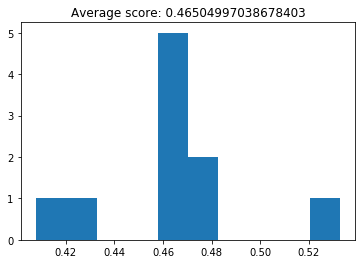

In [110]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

cv_scores = cross_val_score(clf, features_min, labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()

In [113]:
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Precision: {}'.format(grid_search.cv_results_['mean_test_precision_macro'][bestIndex]))
print('Recall: {}'.format(grid_search.cv_results_['mean_test_recall_macro'][bestIndex]))
print('F1_score: {}'.format(grid_search.cv_results_['mean_test_f1_macro'][bestIndex]))
print('Loss: {}'.format(grid_search.cv_results_['mean_test_neg_log_loss'][bestIndex]))
print("Time {:.1f} (seconds)".format((end - start)))

Best score: 0.50210571195818
Best parameters: {'criterion': 'entropy', 'max_features': 1, 'n_estimators': 100}
Precision: 0.4254811751533952
Recall: 0.4325453770350333
F1_score: 0.40788069772888225
Loss: -1.0218908124520516
Time 876.8 (seconds)


# Neural Networks

### Building a Custom Model

In [77]:
model = keras.Sequential(
    [
        keras.layers.Dense(
            8, activation="relu", input_shape=(features.shape[-1],)
        ),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(3, activation="softmax"),
    ]
)
model.summary()
Wsave = model.get_weights()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 8)                 256       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                144       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)               

### Model Training

Train on 17098 samples, validate on 4276 samples
Epoch 1/30
17098/17098 [==============================] - 1s 72us/sample - loss: 1.0626 - acc: 0.4545 - f1_m: 0.1405 - precision_m: 0.5240 - recall_m: 0.0858 - val_loss: 1.0406 - val_acc: 0.4588 - val_f1_m: 0.2654 - val_precision_m: 0.7053 - val_recall_m: 0.1635
Epoch 2/30
17098/17098 [==============================] - 0s 23us/sample - loss: 1.0464 - acc: 0.4596 - f1_m: 0.2389 - precision_m: 0.6050 - recall_m: 0.1542 - val_loss: 1.0274 - val_acc: 0.5056 - val_f1_m: 0.1970 - val_precision_m: 0.7581 - val_recall_m: 0.1139
Epoch 3/30
17098/17098 [==============================] - 0s 26us/sample - loss: 1.0315 - acc: 0.4676 - f1_m: 0.2655 - precision_m: 0.6289 - recall_m: 0.1697 - val_loss: 1.0314 - val_acc: 0.4684 - val_f1_m: 0.1950 - val_precision_m: 0.7836 - val_recall_m: 0.1114
Epoch 4/30
17098/17098 [==============================] - 0s 21us/sample - loss: 1.0252 - acc: 0.4800 - f1_m: 0.2793 - precision_m: 0.6463 - recall_m: 0.1818 - va

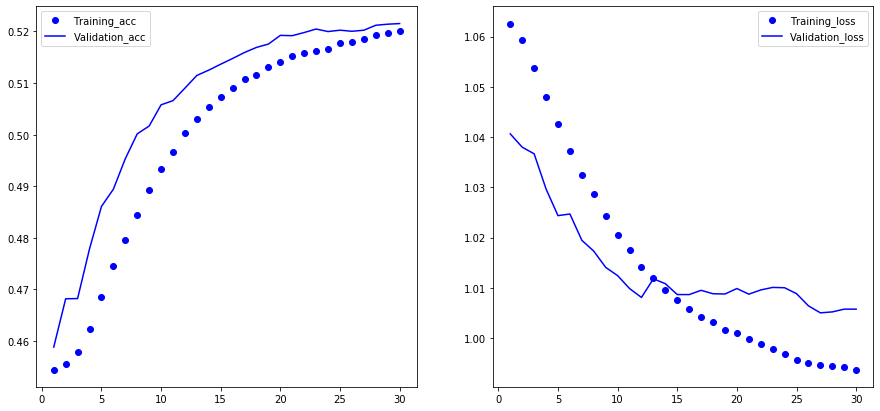

Accuracy: 0.521983
Loss: 1.005715
Precision: 0.702841
Recall: 0.182276
F1 Score: 0.283004


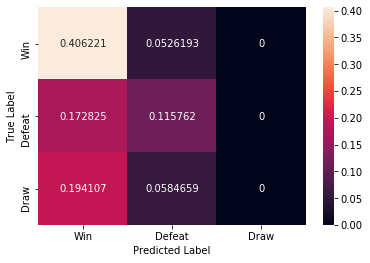

Train on 17099 samples, validate on 4275 samples
Epoch 1/30
17099/17099 [==============================] - 1s 57us/sample - loss: 1.0617 - acc: 0.4543 - f1_m: 0.1578 - precision_m: 0.5200 - recall_m: 0.0987 - val_loss: 1.0509 - val_acc: 0.4589 - val_f1_m: 0.0419 - val_precision_m: 0.6971 - val_recall_m: 0.0216
Epoch 2/30
17099/17099 [==============================] - 0s 18us/sample - loss: 1.0410 - acc: 0.4598 - f1_m: 0.2448 - precision_m: 0.6193 - recall_m: 0.1590 - val_loss: 1.0300 - val_acc: 0.4917 - val_f1_m: 0.2298 - val_precision_m: 0.6615 - val_recall_m: 0.1393
Epoch 3/30
17099/17099 [==============================] - 0s 17us/sample - loss: 1.0279 - acc: 0.4748 - f1_m: 0.2732 - precision_m: 0.6347 - recall_m: 0.1764 - val_loss: 1.0252 - val_acc: 0.4889 - val_f1_m: 0.2414 - val_precision_m: 0.6421 - val_recall_m: 0.1488
Epoch 4/30
17099/17099 [==============================] - 0s 17us/sample - loss: 1.0212 - acc: 0.4911 - f1_m: 0.2867 - precision_m: 0.6324 - recall_m: 0.1880 - va

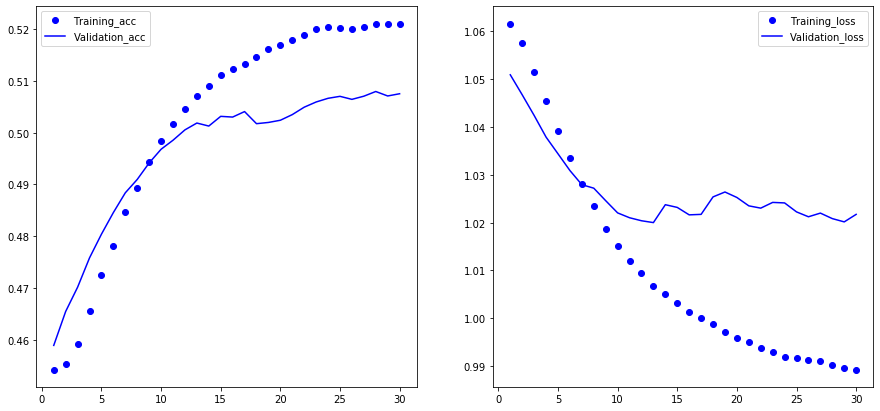

Accuracy: 0.509240
Loss: 1.028026
Precision: 0.716320
Recall: 0.065630
F1 Score: 0.117308


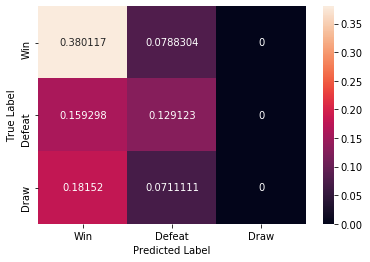

Train on 17099 samples, validate on 4275 samples
Epoch 1/30
17099/17099 [==============================] - 1s 68us/sample - loss: 1.0667 - acc: 0.4553 - f1_m: 0.1373 - precision_m: 0.4868 - recall_m: 0.0845 - val_loss: 1.0583 - val_acc: 0.4589 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
17099/17099 [==============================] - 0s 22us/sample - loss: 1.0508 - acc: 0.4597 - f1_m: 0.2087 - precision_m: 0.6020 - recall_m: 0.1307 - val_loss: 1.0249 - val_acc: 0.4996 - val_f1_m: 0.2286 - val_precision_m: 0.6963 - val_recall_m: 0.1369
Epoch 3/30
17099/17099 [==============================] - 0s 24us/sample - loss: 1.0363 - acc: 0.4652 - f1_m: 0.2569 - precision_m: 0.6246 - recall_m: 0.1637 - val_loss: 1.0064 - val_acc: 0.5085 - val_f1_m: 0.3710 - val_precision_m: 0.6169 - val_recall_m: 0.2654
Epoch 4/30
17099/17099 [==============================] - 0s 19us/sample - loss: 1.0285 - acc: 0.4767 - f1_m: 0.2756 - precision_m: 0.6304 - recall_m:

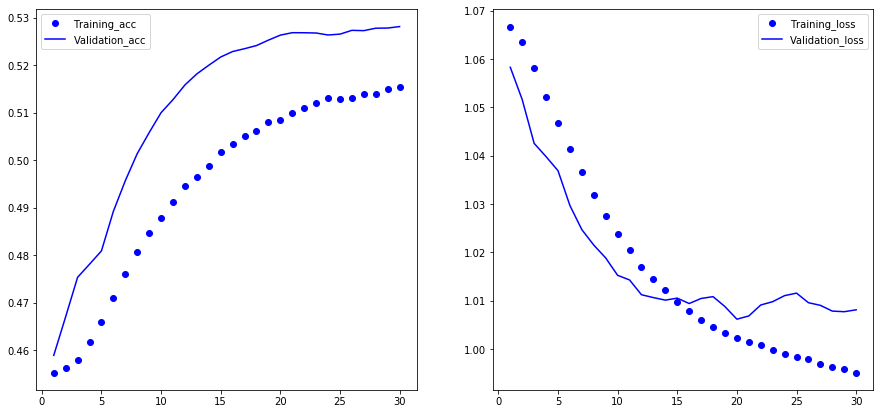

Accuracy: 0.529357
Loss: 1.009705
Precision: 0.709391
Recall: 0.115377
F1 Score: 0.194425


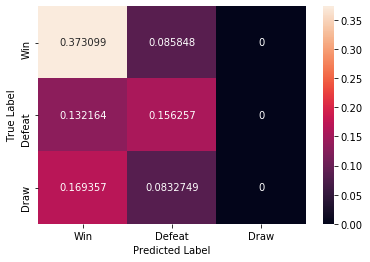

Train on 17100 samples, validate on 4274 samples
Epoch 1/30
17100/17100 [==============================] - 1s 61us/sample - loss: 1.0639 - acc: 0.4525 - f1_m: 0.1481 - precision_m: 0.5209 - recall_m: 0.0918 - val_loss: 1.0521 - val_acc: 0.4591 - val_f1_m: 0.0101 - val_precision_m: 0.7500 - val_recall_m: 0.0051
Epoch 2/30
17100/17100 [==============================] - 0s 22us/sample - loss: 1.0479 - acc: 0.4591 - f1_m: 0.2242 - precision_m: 0.6028 - recall_m: 0.1421 - val_loss: 1.0178 - val_acc: 0.4609 - val_f1_m: 0.2587 - val_precision_m: 0.7242 - val_recall_m: 0.1576
Epoch 3/30
17100/17100 [==============================] - 0s 20us/sample - loss: 1.0343 - acc: 0.4651 - f1_m: 0.2619 - precision_m: 0.6224 - recall_m: 0.1687 - val_loss: 1.0074 - val_acc: 0.5091 - val_f1_m: 0.2640 - val_precision_m: 0.7023 - val_recall_m: 0.1626
Epoch 4/30
17100/17100 [==============================] - 0s 21us/sample - loss: 1.0301 - acc: 0.4787 - f1_m: 0.2747 - precision_m: 0.6309 - recall_m: 0.1788 - va

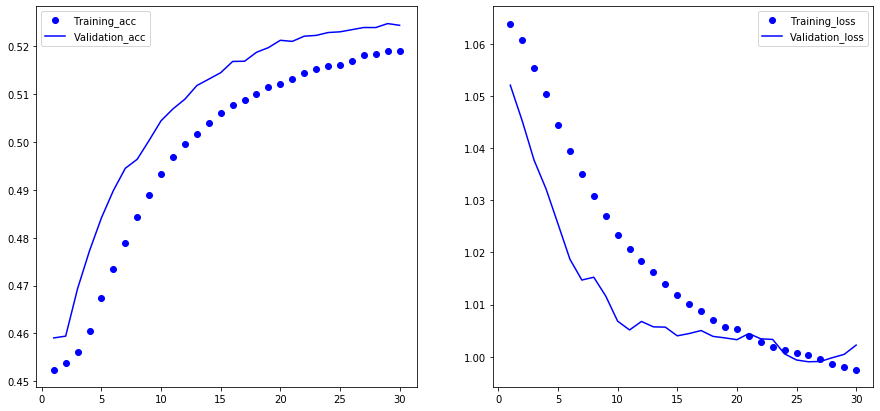

Accuracy: 0.522929
Loss: 1.009307
Precision: 0.655185
Recall: 0.141739
F1 Score: 0.227573


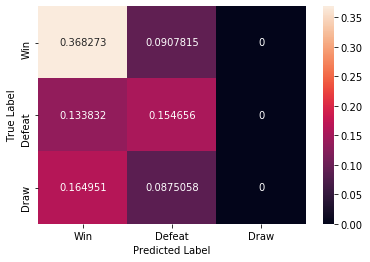

Train on 17100 samples, validate on 4274 samples
Epoch 1/30
17100/17100 [==============================] - 1s 69us/sample - loss: 1.0664 - acc: 0.4527 - f1_m: 0.1314 - precision_m: 0.4858 - recall_m: 0.0816 - val_loss: 1.0537 - val_acc: 0.4591 - val_f1_m: 0.0353 - val_precision_m: 0.9078 - val_recall_m: 0.0180
Epoch 2/30
17100/17100 [==============================] - 0s 26us/sample - loss: 1.0498 - acc: 0.4592 - f1_m: 0.2290 - precision_m: 0.5977 - recall_m: 0.1452 - val_loss: 1.0284 - val_acc: 0.4743 - val_f1_m: 0.2086 - val_precision_m: 0.7224 - val_recall_m: 0.1220
Epoch 3/30
17100/17100 [==============================] - 0s 28us/sample - loss: 1.0333 - acc: 0.4698 - f1_m: 0.2663 - precision_m: 0.6275 - recall_m: 0.1717 - val_loss: 1.0143 - val_acc: 0.4970 - val_f1_m: 0.2723 - val_precision_m: 0.6652 - val_recall_m: 0.1712
Epoch 4/30
17100/17100 [==============================] - 0s 21us/sample - loss: 1.0241 - acc: 0.4807 - f1_m: 0.2874 - precision_m: 0.6349 - recall_m: 0.1873 - va

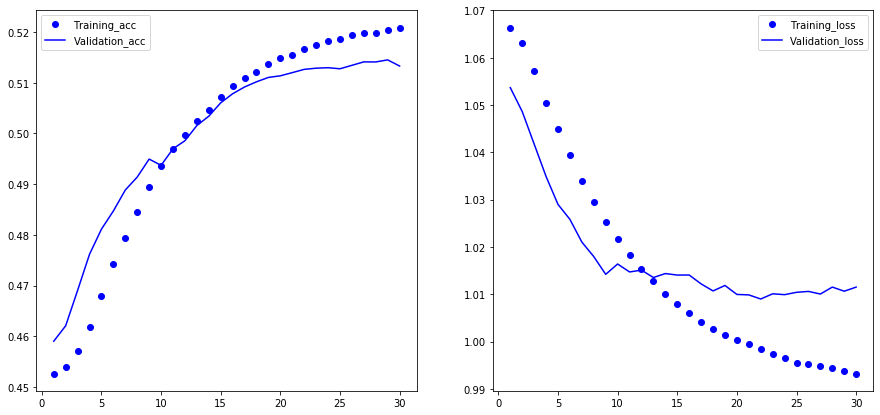

Accuracy: 0.508423
Loss: 1.014982
Precision: 0.645843
Recall: 0.132929
F1 Score: 0.213775


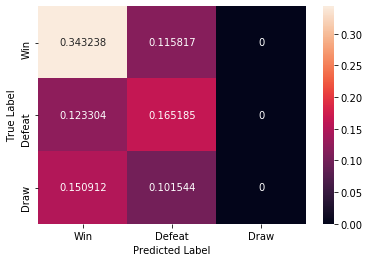

In [78]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def train_and_test_classifier(fold):
    train_features = pd.read_csv(os.path.join('folds' + os.sep + 'train', fold + '.csv')).drop('Unnamed: 0', axis=1)
    train_targets = to_categorical(pd.read_csv(os.path.join('targets' + os.sep + 'train', fold + '.csv')).drop('Unnamed: 0', axis=1))
    val_features = pd.read_csv(os.path.join('folds' + os.sep + 'validate', fold + '.csv')).drop('Unnamed: 0', axis=1)
    val_targets = to_categorical(pd.read_csv(os.path.join('targets' + os.sep + 'validate', fold + '.csv')).drop('Unnamed: 0', axis=1))


    opt = RMSprop(
        lr=0.001
    )

    model.set_weights(Wsave)
    
    model.compile(
       loss='categorical_crossentropy', optimizer=opt, metrics=['acc',f1_m,precision_m, recall_m]
    )


    history = model.fit(
        train_features,
        train_targets,
        batch_size=1024,
        epochs=30,
        validation_data=(val_features, val_targets),
    )

    # Save weights
    model.save_weights(os.path.join('weights' + os.sep + 'custom', fold + '.h5'))
    
    acc = smooth_curve(history.history['acc'])
    val_acc = smooth_curve(history.history['val_acc'])
    loss = smooth_curve(history.history['loss'])
    val_loss = smooth_curve(history.history['val_loss'])
    epochs = range(1, len(acc) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    axs[0].plot(epochs, acc, 'bo', label='Training_acc')
    axs[0].plot(epochs, val_acc, 'b', label='Validation_acc')
    axs[0].legend()
    axs[1].plot(epochs, loss, 'bo', label='Training_loss')
    axs[1].plot(epochs, val_loss, 'b', label='Validation_loss')
    axs[1].legend()
    plt.show()
    
    pred_test= model.predict(val_features)
    loss, accuracy, f1_score, precision, recall = model.evaluate(val_features, val_targets, verbose=0)
    print("Accuracy: %f" % accuracy)
    print("Loss: %f" % loss)
    print("Precision: %f" % precision)
    print("Recall: %f" % recall)
    print("F1 Score: %f" % f1_score)
    
    matrix = metrics.confusion_matrix(val_targets.argmax(axis=1), pred_test.argmax(axis=1))
    matrix = matrix.astype('float') / matrix.sum()
    df_cm = pd.DataFrame(matrix, index = [i for i in ['Win', 'Defeat', 'Draw']],
                  columns = [i for i in ['Win', 'Defeat', 'Draw']])
    ax = sns.heatmap(df_cm, annot=True, fmt='g')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    


# Plot history
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points



for fold in range(5):
    train_and_test_classifier(str(fold + 1))

## Comparing with the Odds

In [74]:
def plot_bookkeeper_cf_matrix(matches, bookkeepers, verbose = False, normalize = True):
    ''' Plot confusion matrix of bookkeeper predictions. '''
    
    if verbose == True: print("Obtaining labels...")
    
    #Get match labels
    y_test_temp = matches.apply(get_match_label, axis = 1)
    
    if verbose == True: print("Obtaining bookkeeper probabilities...")
    
    #Get bookkeeper probabilities
    bookkeeper_probs = get_bookkeeper_probs(matches, bookkeepers)
    bookkeeper_probs.reset_index(inplace = True, drop = True)
    bookkeeper_probs.dropna(inplace = True)
    
    if verbose == True: print("Obtaining bookkeeper labels...")
    
    #Get bookkeeper labels
    y_pred_temp = pd.DataFrame()
    y_pred_temp.loc[:,'bk_label'] = bookkeeper_probs[['Win', 'Defeat', 'Draw']].idxmax(axis = 1)
    y_pred_temp.loc[:,'match_api_id'] = bookkeeper_probs.loc[:, 'match_api_id']
    
    if verbose == True: print("Plotting confusion matrix...")
    print(y_pred_temp.head(5))
    
    #Format data
    results = pd.merge(y_pred_temp, y_test_temp, on = 'match_api_id', how = 'left')
    y_test = results.loc[:, 'label']
    y_pred = results.loc[:, 'bk_label']


    #Generate confusion matrix        
    matrix = confusion_matrix(y_test, y_pred, labels=['Win', 'Defeat', 'Draw']) 
    #Check if matrix should be normalized
    if normalize == True:
        #Normalize
        matrix = matrix.astype('float') / matrix.sum()
    df_cm = pd.DataFrame(matrix, index = [i for i in ['Win', 'Defeat', 'Draw']],
                  columns = [i for i in ['Win', 'Defeat', 'Draw']])
    ax = sns.heatmap(df_cm, annot=True, fmt='g')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    plt.show()

    print("Bookkeeper score for test set: {:.4f}.".format(accuracy_score(y_test, y_pred)))
    
def get_bookkeeper_data(matches, bookkeepers, horizontal = True):
    ''' Aggregates bookkeeper data for all matches and bookkeepers. '''
    
    bk_data = pd.DataFrame()
    
    #Loop through bookkeepers
    for bookkeeper in bookkeepers:

        #Find columns containing data of bookkeeper
        temp_data = matches.loc[:,(matches.columns.str.contains(bookkeeper))]
        temp_data.loc[:, 'bookkeeper'] = str(bookkeeper)
        temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']
        
        #Rename odds columns and convert to numeric
        cols = temp_data.columns.values
        cols[:3] = ['Win','Draw', 'Defeat']
        temp_data.columns = cols
        temp_data.loc[:,'Win'] = pd.to_numeric(temp_data['Win'])
        temp_data.loc[:,'Defeat'] = pd.to_numeric(temp_data['Defeat'])
        temp_data.loc[:,'Draw'] = pd.to_numeric(temp_data['Draw'])
        
        #Check if data should be aggregated horizontally
        if(horizontal == True):
            
            #Convert data to probs
            temp_data = convert_odds_to_prob(temp_data)
            temp_data.drop('match_api_id', axis = 1, inplace = True)
            temp_data.drop('bookkeeper', axis = 1, inplace = True)
            
            #Rename columns with bookkeeper names
            win_name = bookkeeper + "_" + "Win"
            defeat_name = bookkeeper + "_" + "Defeat"
            draw_name = bookkeeper + "_" + "Draw"
            temp_data.columns.values[:3] = [win_name, defeat_name, draw_name]

            #Aggregate data
            bk_data = pd.concat([bk_data, temp_data], axis = 1)
        else:
            #Aggregate vertically
            bk_data = bk_data.append(temp_data, ignore_index = True)
    
    #If horizontal add match api id to data
    if(horizontal == True):
        temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']
    
    #Return bookkeeper data
    return bk_data
    
def get_bookkeeper_probs(matches, bookkeepers, horizontal = False):
    ''' Get bookkeeper data and convert to probabilities for vertical aggregation. '''
    
    #Get bookkeeper data
    data = get_bookkeeper_data(matches, bookkeepers, horizontal = False)
    
    #Convert odds to probabilities
    probs = convert_odds_to_prob(data)
    
    #Return data
    return probs
    
def convert_odds_to_prob(match_odds):
    ''' Converts bookkeeper odds to probabilities. '''
    
    #Define variables
    match_id = match_odds.loc[:,'match_api_id']
    bookkeeper = match_odds.loc[:,'bookkeeper']    
    win_odd = match_odds.loc[:,'Win']
    loss_odd = match_odds.loc[:,'Defeat']
    draw_odd = match_odds.loc[:,'Draw']
    
    #Converts odds to prob
    win_prob = 1 / win_odd
    draw_prob = 1 / draw_odd
    loss_prob = 1 / loss_odd
    
    total_prob = win_prob + draw_prob + loss_prob
    
    probs = pd.DataFrame()
    
    #Define output format and scale probs by sum over all probs
    probs.loc[:,'match_api_id'] = match_id
    probs.loc[:,'bookkeeper'] = bookkeeper
    probs.loc[:,'Win'] = win_prob / total_prob
    probs.loc[:,'Defeat'] = loss_prob / total_prob
    probs.loc[:,'Draw'] = draw_prob / total_prob
    
    #Return probs and meta data
    return probs

def get_match_label(match):
    ''' Derives a label for a given match. '''
    
    #Define variables
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']
     
    label = pd.DataFrame()
    label.loc[0,'match_api_id'] = match['match_api_id'] 

    #Identify match label  
    if home_goals > away_goals:
        label.loc[0,'label'] = "Win"
    if home_goals == away_goals:
        label.loc[0,'label'] = "Draw"
    if home_goals < away_goals:
        label.loc[0,'label'] = "Defeat"

    #Return label        
    return label.loc[0]

Obtaining labels...
Obtaining bookkeeper probabilities...
Obtaining bookkeeper labels...
Plotting confusion matrix...
  bk_label  match_api_id
0      Win        492473
1      Win        492474
2      Win        492475
3      Win        492476
4   Defeat        492477


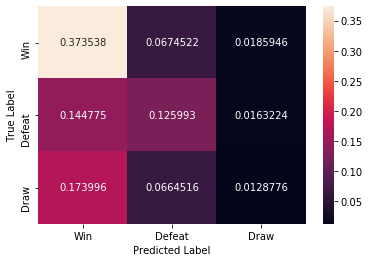

Bookkeeper score for test set: 0.5124.


In [75]:
conn = sqlite3.connect('database.sqlite')

#Fetching required data tables
bk_cols = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']
match_data = pd.read_sql("SELECT * FROM Match;", conn)

plot_bookkeeper_cf_matrix(match_data, bk_cols, verbose = True, normalize = True)